## 1. Workflow for treating missing values:
1. convert all missing values to null values
2. analyze the amount and type of missingness in the data
3. appropriately delete or impute missing values
4. evaluate and compare the perfomances of the treated/imputed dataset

Reference: DataCamp Course "Dealing with Missing Data in Python".

## 2. Load packages, modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import kaggle
import os

In [6]:
def get_titanic_data(folder_path='.\data', force_download=False, file_name='train.csv'):
#download and unzip all the data files for titanic from Kaggle through kaggle api if necessary
#load the data file in dataframe format
    if force_download or not os.path.exists(folder_path):
        !kaggle competitions download -c titanic
        !unzip \*.zip -d $folder_path
        os.remove('titanic.zip')
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    return df

In [7]:
df = get_titanic_data()

## 3. Convert all missing values to null values (None, np.nan)

### 3.1 Find the missing values which are not null values yet

In [7]:
#Check if any of the columns which are supposed to be numerical types are now Object type. The existence of missing values makes numerical columns into Object dtype.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 3.1.1 Check the columns of object dtype

In [16]:
#Find the columns of Object dtype
object_columns = [c for c in df.columns if df[c].dtype == 'object']
object_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [17]:
#Get the number of uniuqe values of each Object columns
df[object_columns].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Skoog, Mr. Wilhelm",male,347082,G6,S
freq,1,577,7,4,644


In [62]:
#Look for common symbols for missing values, like '?', 'NA', '-', '.', 'unknown'
i=1
for c in object_columns:
    print(str(i)+'.', "Top 10 unique values for column '{}':".format(c))
    unique_values = df[c].dropna().unique()
    print(np.sort(unique_values)[:10], '\n')
    print("Is'NA' one of its unique values?", 'NA' in unique_values, '\n')
    unique_values_lowercase = [v.lower() for v in unique_values]
    print("Is 'unknown' (case insensitive) one of its unique values?", 'unknown' in unique_values_lowercase, '\n')
    i+=1

1. Top 10 unique values for column 'Name':
['Abbing, Mr. Anthony' 'Abbott, Mr. Rossmore Edward'
 'Abbott, Mrs. Stanton (Rosa Hunt)' 'Abelson, Mr. Samuel'
 'Abelson, Mrs. Samuel (Hannah Wizosky)' 'Adahl, Mr. Mauritz Nils Martin'
 'Adams, Mr. John' 'Ahlin, Mrs. Johan (Johanna Persdotter Larsson)'
 'Aks, Mrs. Sam (Leah Rosen)' 'Albimona, Mr. Nassef Cassem'] 

Is'NA' one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

2. Top 10 unique values for column 'Sex':
['female' 'male'] 

Is'NA' one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

3. Top 10 unique values for column 'Ticket':
['110152' '110413' '110465' '110564' '110813' '111240' '111320' '111361'
 '111369' '111426'] 

Is'NA' one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

4. Top 10 unique values for column 'Cabin':
['A10' 'A14' 'A16' 'A19' 'A20' 'A23' 'A24' 'A26' 'A31' 'A32'] 

Is'NA' one

#### Comment:
The common symbols or words representing missing values are not found in the Object columns. 

#### 3.1.2 Check the numerical columns

In [8]:
#Look for values out of expected data range, like 0 for age, or extremely large number like 9999 for age
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [63]:
df[df.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


#### Comment:
The minimum fare is zero, involving 15 tickets.It may indicate free tickets or missing values.However, Tammy found the evidence about the complimentary ticket for John George( https://www.kaggle.com/c/titanic/discussion/10570). As not any evidence was found about the missing fare data marked as 0, I interpreted the value 0 as it is (meaning free ticket).

No unusal numerical values have been found representing missing values.

## 4. Analyze the amount and type of missingness in the data

### 4.1 Analyze the amount of missingness

In [64]:
# Amount of missingness
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [65]:
#Percentage of missingness
df.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

#### Comment:
687 (77%) Cabin values are missing.Very large proportion!  
177 (20%) Age values are missing. Not small proportion.  
2 (0.2%) Embarked values are missing. Very small proportion.

### 4.2 Analyze the types of missingness (MCAR, MAR, MNAR)

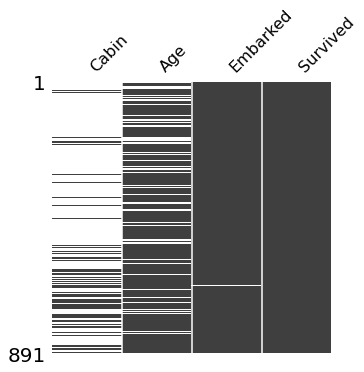

In [102]:
#Check nullity matrix for the columns with missingness and the column used to sort the data
df_sorted = df.sort_values(by='Survived')
cols_missing = ['Cabin', 'Age', 'Embarked']
cols_matrix = cols_missing.copy()
cols_matrix.append('Survived')
msno.matrix(df_sorted[cols_matrix], figsize=(5, 5), sparkline=False);

In [115]:
#Get the missing percentage for the victims
missing_cabin_vic = df.loc[df.Survived==0, 'Cabin'].isnull().mean()*100
#Get the missing percentage for the survivors
missing_cabin_sur = df.loc[df.Survived==1, 'Cabin'].isnull().mean()*100
print("Missingness percentage of Cabin for the victims: {}%".format(round(missing_cabin_vic)))
print("Missingness percentage of Cabin for the survivors: {}%".format(round(missing_cabin_sur)))      

Missingness percentage of Cabin for the victims: 88.0%
Missingness percentage of Cabin for the survivors: 60.0%


#### Comment:
The missing values are shown as white lines in the msno matrix.  

As shown in the matrix, in the 'Cabin' column, the upper part is whiter than its lower part, indicating that more missing values of 'Cabin' are found for the victims than for the survivors.It's confirmed by checking the missing percentages for the survivors and the victims. So the 'Cabin' column can not be categorized as 'MCAR'.

In the 'Age column, the upper part doesn't look whiter or darker than its lower part, indicating no strong relationship between the 'Survived' variable and the missingness of 'Age'. Whether its missingness is related with the variable other than 'Survived', needs to be further investigated..

Even though the two missing values of 'Embarked' are all for the survivors, considering the very few missing values, it doesn't necessarily mean the strong relationship between the 'Survived' variable and the missingness of 'Embarked'. Since only a few values are missing, the 'Embarked'column can be categorized as 'MCAR'.

Nullity matrix for data sorted by column 'PassengerId'


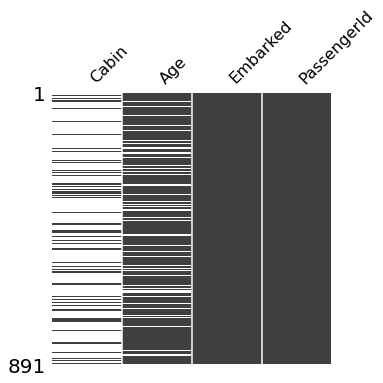

Nullity matrix for data sorted by column 'Survived'


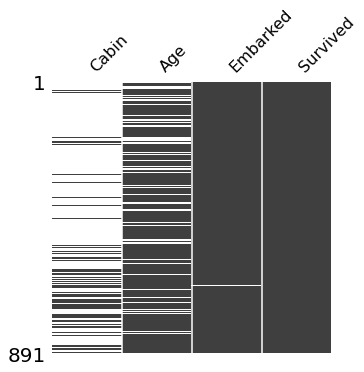

Nullity matrix for data sorted by column 'Pclass'


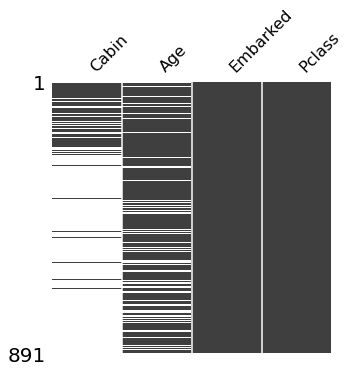

Nullity matrix for data sorted by column 'Name'


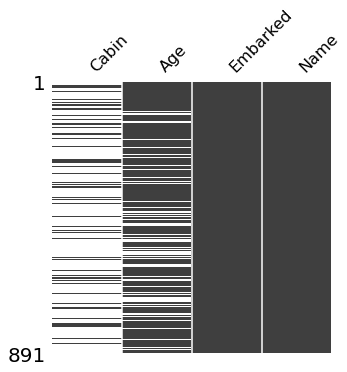

Nullity matrix for data sorted by column 'Sex'


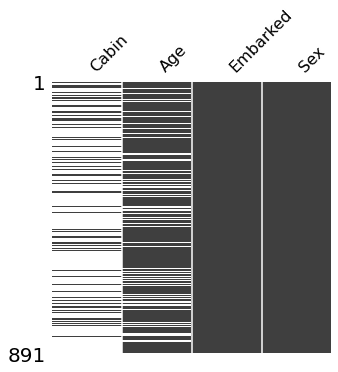

Nullity matrix for data sorted by column 'Age'


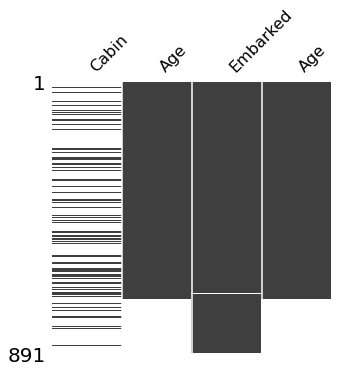

Nullity matrix for data sorted by column 'SibSp'


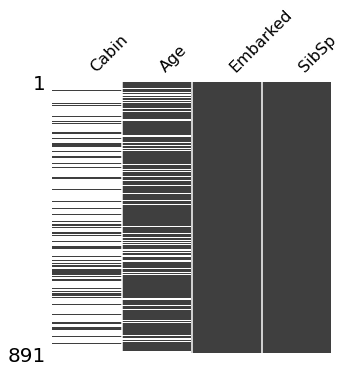

Nullity matrix for data sorted by column 'Parch'


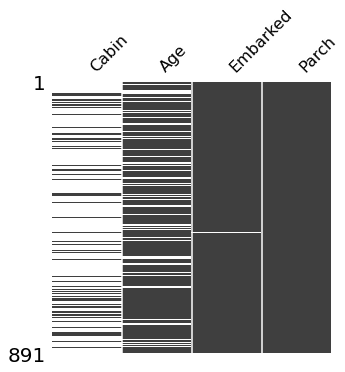

Nullity matrix for data sorted by column 'Ticket'


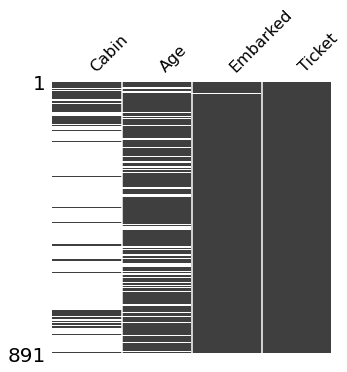

Nullity matrix for data sorted by column 'Fare'


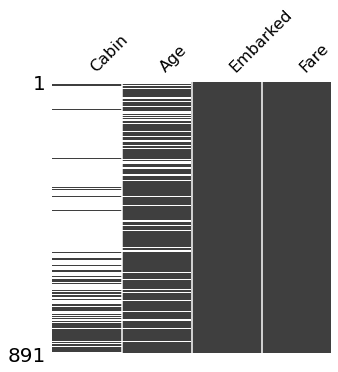

Nullity matrix for data sorted by column 'Cabin'


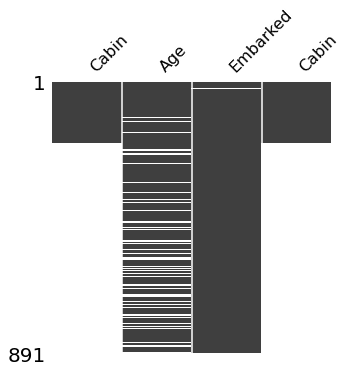

Nullity matrix for data sorted by column 'Embarked'


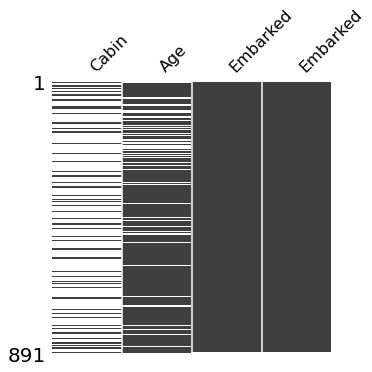

In [135]:
for c in df.columns:
    df_sorted = df.sort_values(by=c)
    cols_matrix = cols_missing.copy()
    cols_matrix.append(c)
    print("Nullity matrix for data sorted by column '{}'".format(c))
    msno.matrix(df_sorted[cols_matrix], figsize=(5, 5), sparkline=False)
    plt.show()